[ 23  74 144 178 225 282 333] 7
[1.0, 23, 1, 0.5682364718564056, 74, 1, 0.1535256208683001, 144, 1, 0.17279800400847992, 178, 1, 0.07683152457571446, 225, 1, 0.0919772271060542, 282, 1, 0.1136369291383032, 333, 1]
[8.50953863e-01 1.99278585e+01 2.96998448e+01 2.77037837e-01
 7.27921438e+01 1.48031228e+01 1.41160540e-01 1.12681803e+02
 3.77503543e+01 9.50834435e-02 1.78700846e+02 1.38985620e+01
 2.86865633e-02 2.27398691e+02 1.25754171e+01 6.05246372e-02
 2.82753340e+02 1.31273466e+01 7.81269820e-02 3.36549279e+02
 1.98773229e+01]


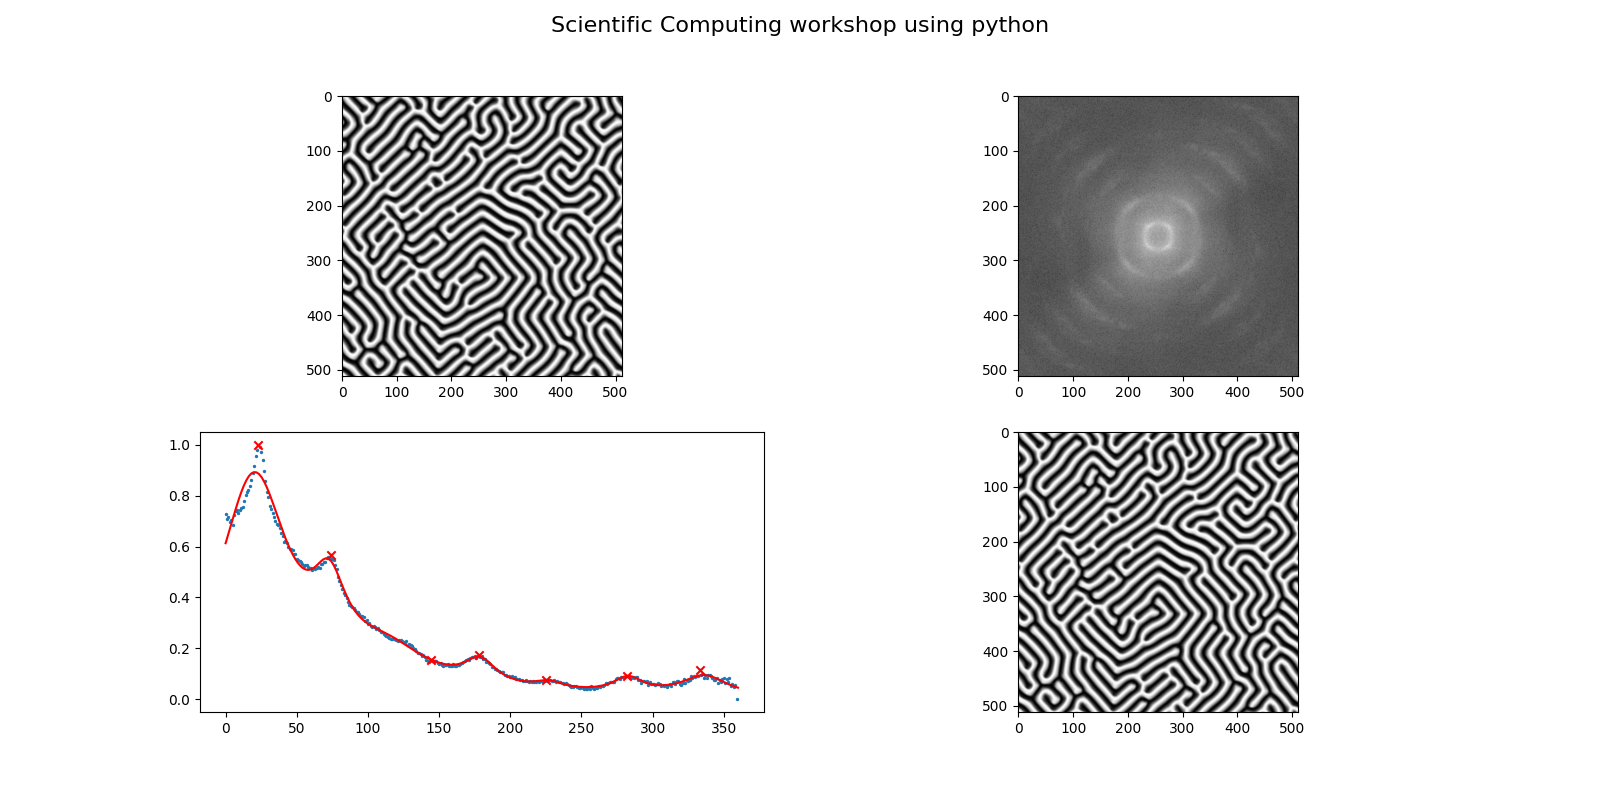

In [90]:
%matplotlib widget

import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as opt
import radialProfile
from scipy.optimize import curve_fit

def radial_profile(data):
    center = (np.round(data.shape[0]), np.round(data.shape[1]))
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

# Lorentzian function
def lorentzian(x, amplitude, x0, gamma):
    return amplitude * gamma**2 / ((x - x0)**2 + gamma**2)

# Sum of Lorentzian functions
def sum_of_lorentzians(x, *params):
    y = 0
    for i in range(0, len(params), 3):
        y += lorentzian(x, params[i], params[i+1], params[i+2])
    return y




if __name__ == "__main__":
    img = cv2.imread('test4.png',cv2.IMREAD_GRAYSCALE)


    # Create the FFT of image
    freq_space = np.fft.fft2(img)
    # Shift the Fourier transform to the center
    fshift = np.fft.fftshift(freq_space)
    # Calculate the magnitude spectrum
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    
    # Calculate the radial profile
    rad_prof = radialProfile.azimuthalAverage(magnitude_spectrum)
    rad_prof = rad_prof[~np.isnan(rad_prof)]
    rad_prof = (rad_prof-np.min(rad_prof))/(np.max(rad_prof)-np.min(rad_prof))
    
    fig, ax = plt.subplots(2,2, figsize=(16,8))
    
    peaks, props = scipy.signal.find_peaks(rad_prof, width=4)
    #print(peaks)
    
    X = range(rad_prof.shape[0])
    popt, pcov = opt.curve_fit(lorentzian, X, rad_prof, [peaks[0], 1, 1])

    ax[0,0].imshow(img, cmap='gray')
    ax[0,1].imshow(magnitude_spectrum, cmap='gray')
    
    ax[1,0].scatter(X, rad_prof, s=2)
    ax[1,0].scatter(peaks, rad_prof[peaks], c='r', marker='x', zorder=3)


    x_param = np.linspace(0,len(X), 200)
    
    print(peaks, len(peaks))
    n = len(peaks)
    init_params = [1] * (3 * len(peaks))
    for i in range(n):
        init_params[3*i+1] = peaks[i]
        init_params[3*i] = rad_prof[peaks[i]]
    
    print(init_params)
    params, _ = curve_fit(sum_of_lorentzians, X, rad_prof, list(init_params), maxfev=10000000)
    print(params)

    #ax[1,0].plot(x_param, lorentzian(x_param, popt[0], popt[1], popt[2]), c='g')
    ax[1,0].plot(x_param, sum_of_lorentzians(x_param, *params), c='r')

    # Inverse FFT
    rev_im = np.fft.ifft2(freq_space)
    ax[1,1].imshow(np.abs(rev_im), cmap='gray')

    fig.suptitle('Scientific Computing workshop using python', fontsize=16)

    plt.show()

In [55]:
params = [10, 20, 30]
arr = [1] * (3 * len(params))
for i in range(len(params)):
    arr[3*i+1] = params[i]

arr

[1, 10, 1, 1, 20, 1, 1, 30, 1]

In [35]:
x = np.linspace(-5, 5, 101)
y = np.linspace(-5, 5, 101)
# full coordinate arrays
xx, yy = np.meshgrid(x, y)
zz = np.sqrt(xx**2 + yy**2)
xx.shape, yy.shape, zz.shape

((101, 101), (101, 101), (101, 101))

In [36]:
# sparse coordinate arrays
xs, ys = np.meshgrid(x, y, sparse=True)
zs = np.sqrt(xs**2 + ys**2)
xs.shape, ys.shape, zs.shape

((1, 101), (101, 1), (101, 101))

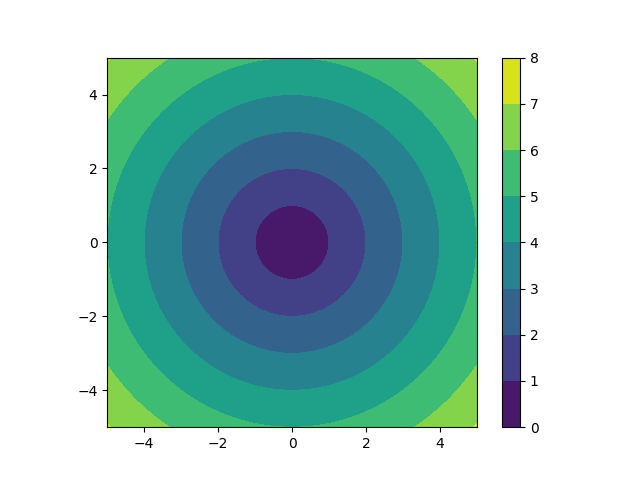

In [37]:
ax1 = plt.figure().add_subplot()
h = plt.contourf(x, y, zs)
plt.axis('scaled')
plt.colorbar()
plt.show()

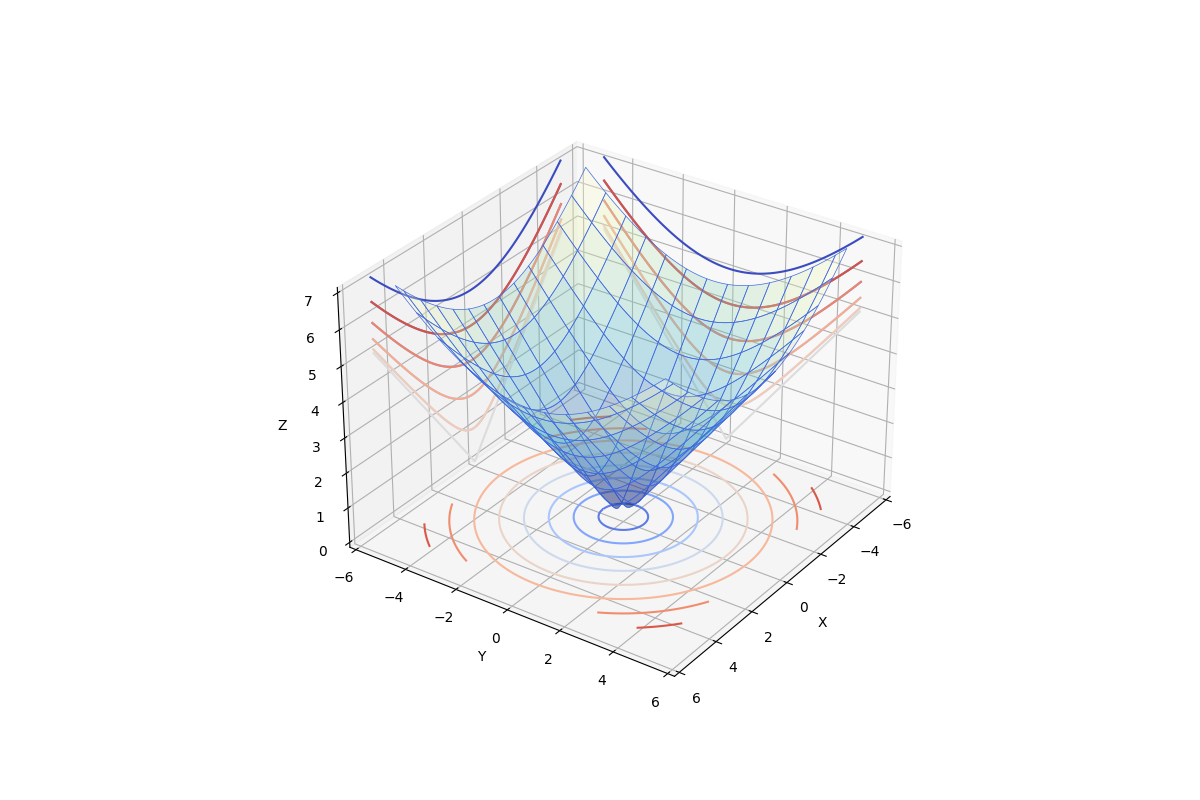

In [38]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')


ax.plot_surface(xs, ys, zs, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3, cmap=plt.cm.YlGnBu_r)

#for angle in range(0, 360):
ax.view_init(30, 35)

ax.contour(xx, yy, zs, zdir='z', offset=0, levels=10, cmap='coolwarm')
ax.contour(xx, yy, zs, zdir='x', offset=-6, levels=10, cmap='coolwarm')
ax.contour(xx, yy, zs, zdir='y', offset=-6, levels=10, cmap='coolwarm')

ax.set(xlim=(-6, 6), ylim=(-6, 6), zlim=(0, 7),
       xlabel='X', ylabel='Y', zlabel='Z')


plt.show()


## 3D plotting and 3-dimensional data

- Many systems and their behaviour can be studied using multi-dimensional data
    - From simple systems such as an electric potential over a conducting surface to abstractions of physical systems, such as micromagnetic structure energies w.r.t. 2 parameters
- If possible, problems should always be reduced such that the analysis is easier to understand visually
    - In scientific publishing clear visualization is key: it is much easier to explain system behaviour using simple to understand visualization of data instead of throwing complicated and cumbersome graphs at people
- Sometimes reducing the problem to a simpler one isn't possible or reasonable.
    - Sometimes more complex visualization techniques give a much fuller picture of the system behaviour we are studying


### Multi-dimensional data and handling it

<i>One of the best ways to handle data in Python is with Pandas library</i>.<br>
Pandas is specifically developed for data analysis and handling and presents a <b>lot</b> of pre-built tools for manipulating complex dataframes.

In addition <i>numerical python</i>, or Numpy as its called among friends, is also a great tool and we'll be employing that very soon.

Let's take a look at a couple examples.


#### You can mostly skip this first code block for now, since Pandas will be the topic of Nico and Teemu in the coming workshops.

In [39]:
# Import the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate a Lorentzian value
def Lorentzian(x, x0, a, gam):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

np.random.seed(42)

X = np.linspace(-5,5,100)
Y = Lorentzian(X, 0, 1, 1) + np.random.normal(0, 0.1, 100)
# Create a Pandas dataframe filled with random numbers in a Lorentzian distribution
df = pd.DataFrame({'X': X,'Y': Y})

# Show the dataframe transposed (for better visualization)
df.T

0         1        2         3         4         5         6   \
X -5.000000 -4.898990 -4.79798 -4.696970 -4.595960 -4.494949 -4.393939   
Y  0.088133  0.026173  0.10640  0.195665  0.021787  0.023746  0.207166   

         7         8         9   ...        90        91        92        93  \
X -4.292929 -4.191919 -4.090909  ...  4.090909  4.191919  4.292929  4.393939   
Y  0.128212  0.006897  0.110640  ...  0.066092  0.150708 -0.018736  0.016479   

         94        95        96        97        98        99  
X  4.494949  4.595960  4.696970  4.797980  4.898990  5.000000  
Y  0.007949 -0.101149  0.072974  0.067736  0.040511  0.015003  

[2 rows x 100 columns]

So now we have a 2-dimensional <b>dataframe</b>, a Pandas data structure, to store some created data. In actual application this could be simulated, calculated or experimentally measured data.

Let us see how we did with the creation of the data. Let's plot it!

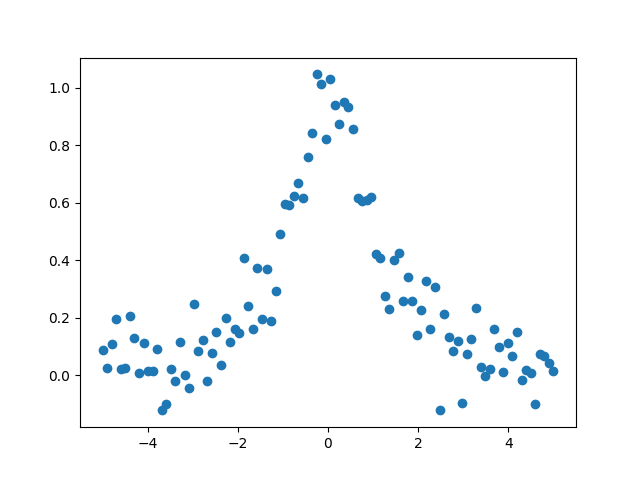

In [40]:
# Create a figure and plot the data
ax = plt.figure().add_subplot()
ax.plot(df['X'], df['Y'], 'o')
plt.show()

So now we see very clearly the data we created is a Lorentzian distribution with some error added in for good measure. Now then, how should we proceed if instead we wanted to create a 3-dimensional image?

So what we want to do is plot a 3rd variable as a function of other 2, say if we wanted to visualize a similar Lorentzian peak in 3D space. Then the 2 known variables would be our $x$ and $y$ spatial directions and the 3rd would be the height $z$ of the distribution at a given point $(x,y)$.

In this problem we can employ Numpy and one of its incredibly useful functions: a <b>meshgrid</b>.

Meshgrid takes in as arguments $n$ arrays (or what are known as list-like objects). It then determines these as the "axes" of an $n$-dimensional array. The function returns $n$ $n$-dimensional arrays, for each given dimension and fills in the values of the corresponding coordinate. Afterwards these arrays can be used to calculate, say, function values at each of the points in the defined space. So meshgrid shines the brightest when you need to <b>evaluate scalar or vector fields</b>.

In [41]:

# Create meshgrids for x and y
gridx, gridy = np.meshgrid(X, X, indexing='xy')

gridx, gridy


(array([[-5.       , -4.8989899, -4.7979798, ...,  4.7979798,  4.8989899,
          5.       ],
        [-5.       , -4.8989899, -4.7979798, ...,  4.7979798,  4.8989899,
          5.       ],
        [-5.       , -4.8989899, -4.7979798, ...,  4.7979798,  4.8989899,
          5.       ],
        ...,
        [-5.       , -4.8989899, -4.7979798, ...,  4.7979798,  4.8989899,
          5.       ],
        [-5.       , -4.8989899, -4.7979798, ...,  4.7979798,  4.8989899,
          5.       ],
        [-5.       , -4.8989899, -4.7979798, ...,  4.7979798,  4.8989899,
          5.       ]]),
 array([[-5.       , -5.       , -5.       , ..., -5.       , -5.       ,
         -5.       ],
        [-4.8989899, -4.8989899, -4.8989899, ..., -4.8989899, -4.8989899,
         -4.8989899],
        [-4.7979798, -4.7979798, -4.7979798, ..., -4.7979798, -4.7979798,
         -4.7979798],
        ...,
        [ 4.7979798,  4.7979798,  4.7979798, ...,  4.7979798,  4.7979798,
          4.7979798],
        [ 4.

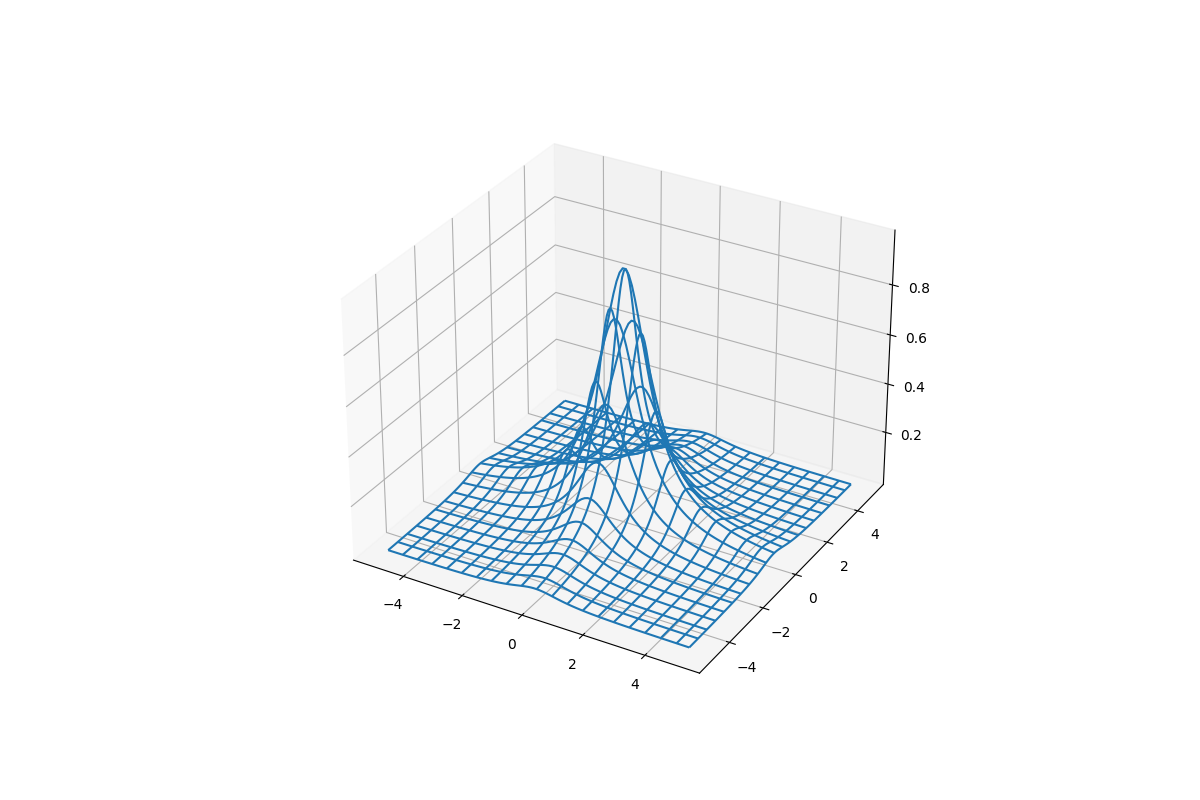

In [42]:

# Calculate z values
zvals = Lorentzian(gridx, 0, 1, 1) * Lorentzian(gridy, 0, 1, 1)

#zvals = (Lorentzian(gridx, 0, 1, 1) + np.random.normal(0, 0.1, 100)) * (Lorentzian(gridy, 0, 1, 1) + np.random.normal(0, 0.1, 100))

ax = plt.figure(figsize=(12,8)).add_subplot(projection='3d')
ax.plot_wireframe(gridx, gridy, zvals, cmap='viridis', rstride=5, cstride=5)

plt.show()

Now then! We have acquired some tools to visualize multidimensional data or, say 2-dimensional scalar fields for examples. What if we had some actual data to visualize. Well gladly we do! So let's do some actual science!

Let's read in some actual measurement data:

In [43]:
# Load in the equipotential dataset, courtesy of Simo Soini
df = pd.read_csv('equipotential.csv', index_col=0, header=0)
df

0     1     2     3      4     5     6     7     8     9  ...    19  \
20  6.70  6.20  6.15  6.10   5.95  6.64  6.48  6.27  6.06  5.79  ...  3.33   
19  7.21  6.28  6.26  6.18   6.05  6.67  6.54  6.32  6.10  5.81  ...  3.33   
18  6.80  6.20  6.36  6.28   6.18  6.74  6.62  6.40  6.15  5.87  ...  3.27   
17  6.86  6.49  6.51  6.38   6.25  6.88  6.64  6.48  6.21  5.97  ...  3.22   
16  7.05  6.60  6.53  6.49   6.35  7.00  6.81  6.53  6.33  5.98  ...  3.16   
15  7.33  6.80  6.78  7.58   7.10  7.20  6.96  6.72  6.42  6.11  ...  3.08   
14  7.58  7.04  7.02  7.84   7.56  7.41  7.13  6.88  6.57  6.23  ...  2.97   
13  7.81  7.25  7.21  8.15   7.95  7.73  7.48  7.03  6.70  6.26  ...  2.88   
12  7.88  7.49  7.54  8.72   8.20  8.47  7.89  7.31  6.81  6.39  ...  2.80   
11  8.13  7.50  7.91  9.60   9.51  9.30  8.32  7.55  6.96  6.48  ...  2.77   
10  3.83  7.60  8.14  9.72  10.00  8.33  8.34  7.28  6.90  6.43  ...  2.83   
9   8.10  7.73  8.05  8.20   9.77  9.20  8.12  7.48  6.84  6.52  ...  2.94   
8   7.98  7.45  7.50  6.90   8.44  8.12  7.78  7.35  6.72  6.42  ...  2.97   
7   6.80  7.25  7.30  6.25   8.06  7.76  7.47  7.16  6.67  6.33  ...  3.09   
6   7.35  7.07  6.97  6.35   7.64  7.49  7.25  6.86  6.58  6.29  ...  3.19   
5   6.70  6.91  6.86  6.23   7.44  7.27  7.03  6.78  6.50  6.19  ...  3.28   
4   7.02  6.76  6.59  6.41   7.22  7.04  6.81  6.59  6.39  6.11  ...  3.33   
3   6.83  6.59  6.55  6.43   7.11  6.93  6.72  6.54  6.31  6.07  ...  3.41   
2   6.98  7.27  6.55  6.35   6.97  6.79  6.63  6.38  6.23  5.99  ...  3.45   
1   6.89  6.38  6.83  6.31   6.85  6.70  6.57  6.38  6.20  5.98  ...  3.50   
0   7.21  6.27  6.26  6.30   6.78  6.67  6.52  6.36  6.17  5.96  ...  3.51   

      20    21    22    23    24    25    26    27    28  
20  3.16  2.97  2.81  2.65  2.51  2.40  2.31  2.27  2.24  
19  3.14  2.95  2.75  2.60  2.44  2.35  2.27  2.22  2.20  
18  3.08  2.90  2.68  2.52  2.38  2.26  2.18  2.14  2.11  
17  3.04  2.80  2.57  2.40  2.26  2.16  2.06  2.01  2.00  
16  2.92  2.69  2.46  2.27  2.11  2.00  1.89  1.86  1.86  
15  2.80  2.55  2.22  2.04  1.86  1.75  1.68  1.65  1.65  
14  2.70  2.40  2.00  1.73  1.57  1.48  1.41  1.43  1.42  
13  2.56  2.17  1.70  1.38  1.22  1.14  1.13  1.19  1.22  
12  2.47  1.90  1.34  0.94  0.66  0.72  0.84  0.96  1.01  
11  2.33  1.77  1.04  0.27  0.08  0.23  0.58  0.80  0.87  
10  2.29  1.64  0.71  0.15  0.00  0.05  0.51  0.76  0.86  
9   2.49  2.00  1.25  0.61  0.12  0.35  0.65  0.85  0.96  
8   2.61  2.21  1.70  1.39  1.13  1.02  1.08  1.13  1.17  
7   2.75  2.40  2.03  1.80  1.55  1.46  1.44  1.38  1.39  
6   2.91  2.58  2.28  2.13  1.89  1.79  1.71  1.66  1.62  
5   3.01  2.76  2.50  2.34  2.16  2.01  1.95  1.89  1.85  
4   3.09  2.88  2.65  2.50  2.33  2.22  2.12  2.09  2.06  
3   3.18  2.99  2.82  2.64  2.47  2.38  2.29  2.24  2.21  
2   3.26  3.07  2.88  2.75  2.60  2.50  2.41  2.36  2.34  
1   3.31  3.14  2.96  2.81  2.70  2.58  2.51  2.46  2.43  
0   3.33  3.17  2.98  2.85  2.74  2.63  2.57  2.49  2.47  

[21 rows x 29 columns]

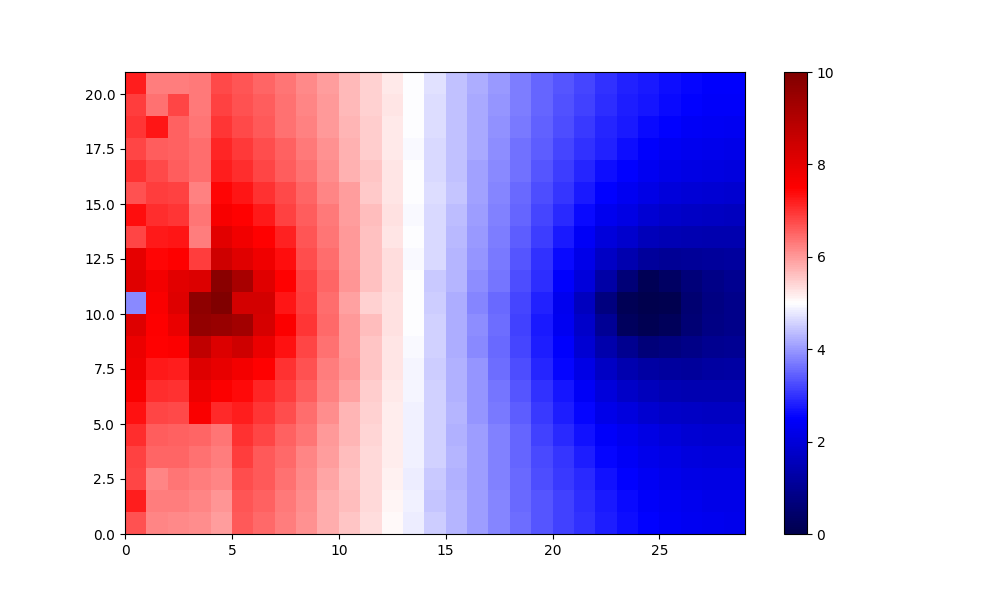

In [44]:
ax = plt.figure(figsize=(10,6)).add_subplot()
image = ax.pcolormesh(df, cmap='seismic')
plt.colorbar(image)
plt.show()

Okay! Now we are cooking! How about a 3-dimensional representation?

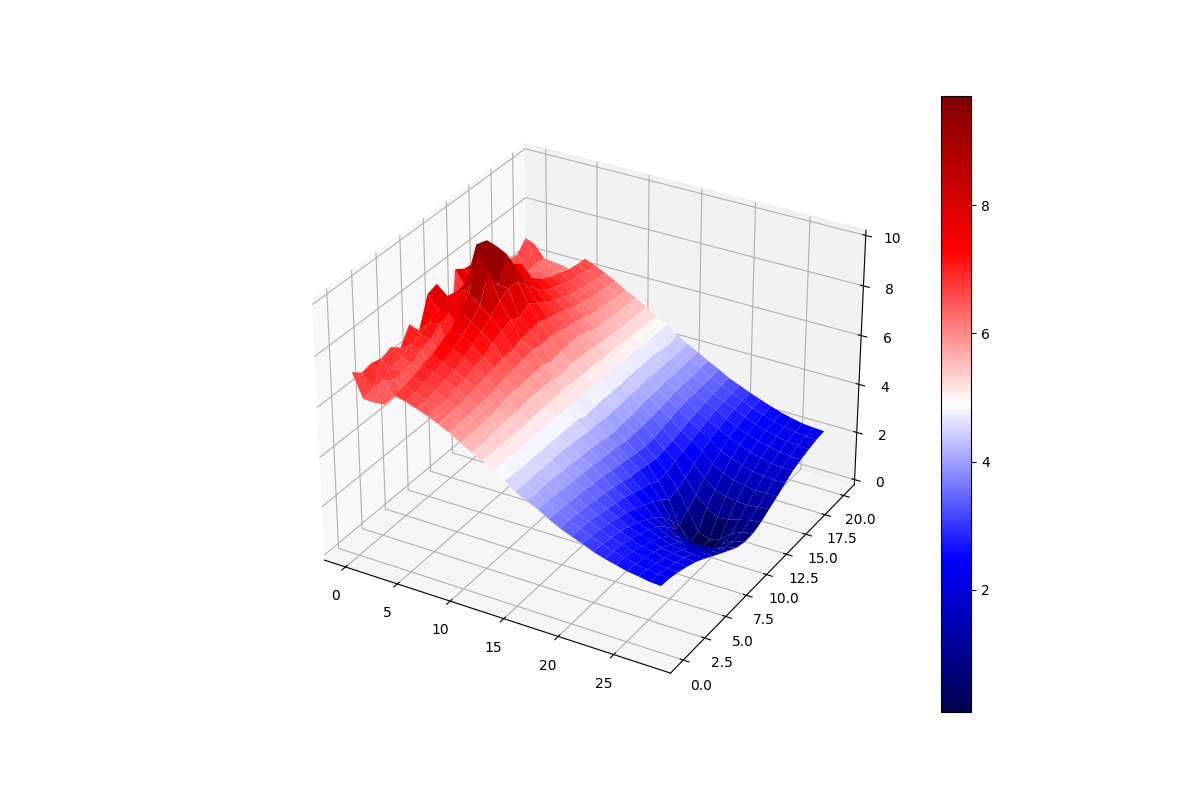

In [45]:
# Create meshgrids for x and y positions
# Don't mind the map function too much, it only converts the dataframe 
# axis labels to floats so they can be passed to matplotlib
X, Y = np.meshgrid(df.columns.map(float), df.index, indexing='xy')
ax = plt.figure(figsize=(12,8)).add_subplot(projection='3d')

Z = df.values

image = ax.plot_surface(X, Y, Z, cmap='seismic')
plt.colorbar(image)
plt.show()

Now this is all well and good. But what if we wanted the data to look a bit smoother. If we could go back to redo the measurements that would obviously be our top choice. But how should we proceed when that is not possible?

There are many ways to estimate intermediate values between measured ones. One way to smoothen this kind of data is <i>interpolation</i>. Interpolation estimates the values between known ones by different methods. Typical methods are linear, nearest neighbour, cubic and quintinc interpolation. To those familiar with image processing these terms may ring a bell: When image resolution is increased the new image is actually an interpolation of the original one. The resolution is increased by estimating the intermediate values between known pixels using interpolation.

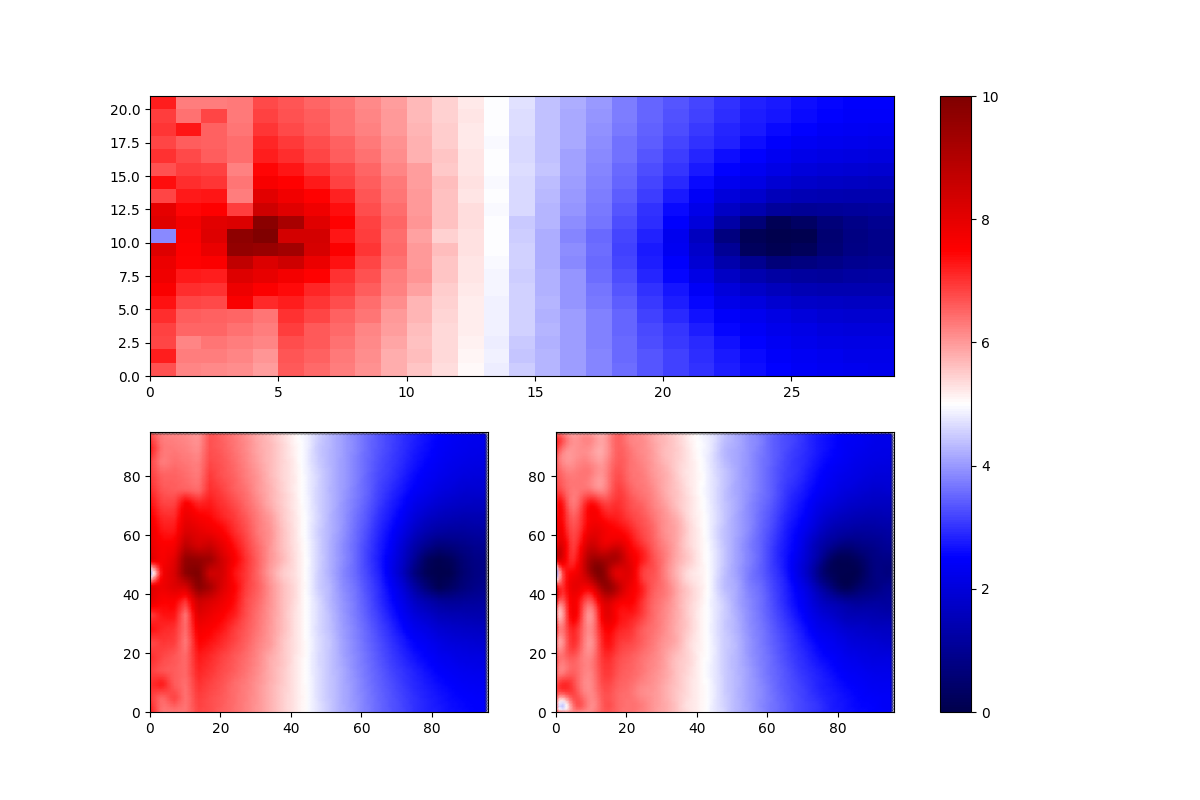

In [46]:
import scipy.interpolate as interp

ax = plt.figure(figsize=(12,8)).add_subplot(211)

x = np.linspace(0, 29, 100)
y = np.linspace(0, 21, 100)


fit_points = [df.columns.map(float), df.index]
values = Z.T

ut, vt = np.meshgrid(x, y, indexing='xy')
test_points = np.array([ut.ravel(), vt.ravel()]).T

interpolator = interp.RegularGridInterpolator(fit_points, values, bounds_error=False)
interpolated_z = interpolator(test_points, method='linear', ).reshape(ut.shape)
interpolated_z2 = interpolator(test_points, method='quintic', ).reshape(ut.shape)


image = ax.pcolormesh(df, cmap='seismic')

ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

ax2.pcolormesh(interpolated_z, shading='gouraud', cmap='seismic')
ax2.set_xlim(0, 96)
ax2.set_ylim(0, 95)

ax3.pcolormesh(interpolated_z2, shading='gouraud', cmap='seismic')
ax3.set_xlim(0, 96)
ax3.set_ylim(0, 95)

plt.colorbar(image, ax=[ax, ax2, ax3])

plt.show()

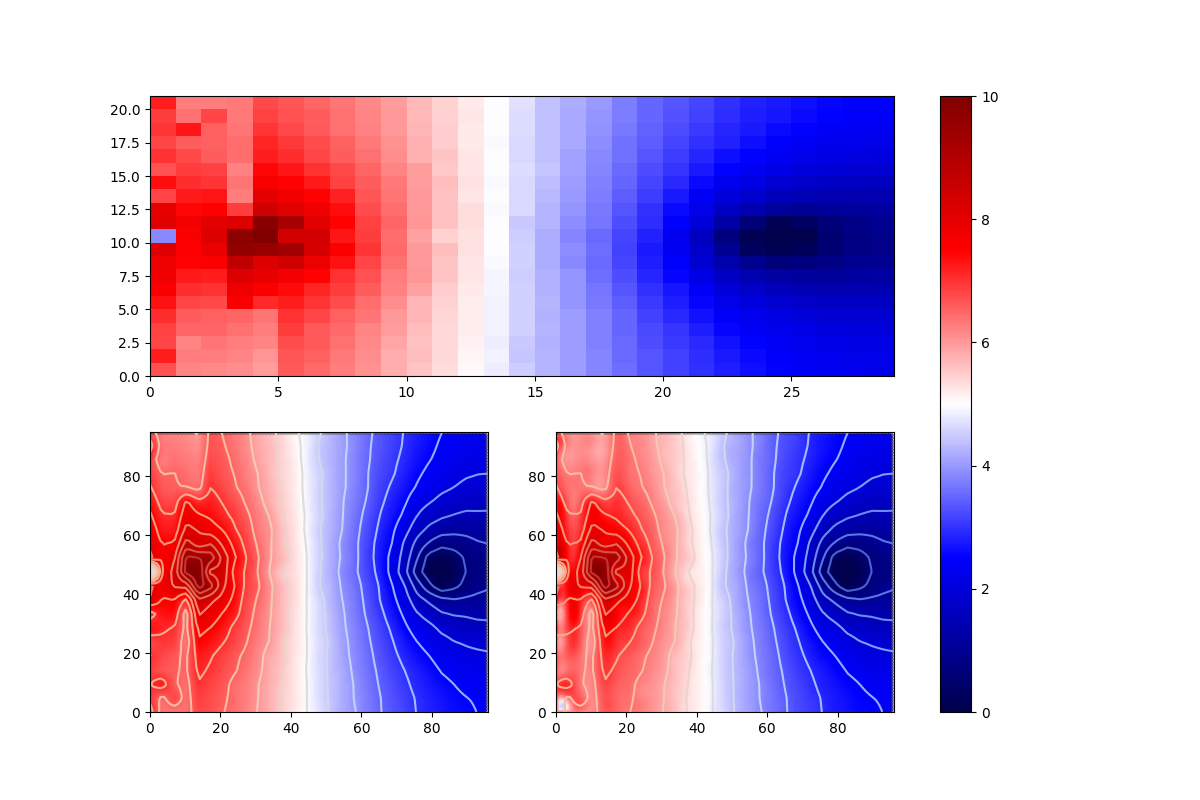

In [47]:

ax = plt.figure(figsize=(12,8)).add_subplot(211)

ax.pcolormesh(df, cmap='seismic')

ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

ax2.pcolormesh(interpolated_z, shading='gouraud', cmap='seismic')
newx, newy = np.meshgrid(np.linspace(0,100,100), np.linspace(0,100,100), indexing='xy')
ax2.contour(newx, newy, interpolated_z, levels=20, cmap='coolwarm')
ax2.set_xlim(0, 96)
ax2.set_ylim(0, 95)

ax3.pcolormesh(interpolated_z2, shading='gouraud', cmap='seismic')
ax3.contour(newx, newy, interpolated_z, levels=20, cmap='coolwarm')
ax3.set_xlim(0, 96)
ax3.set_ylim(0, 95)

plt.colorbar(image, ax=[ax, ax2, ax3])

plt.show()

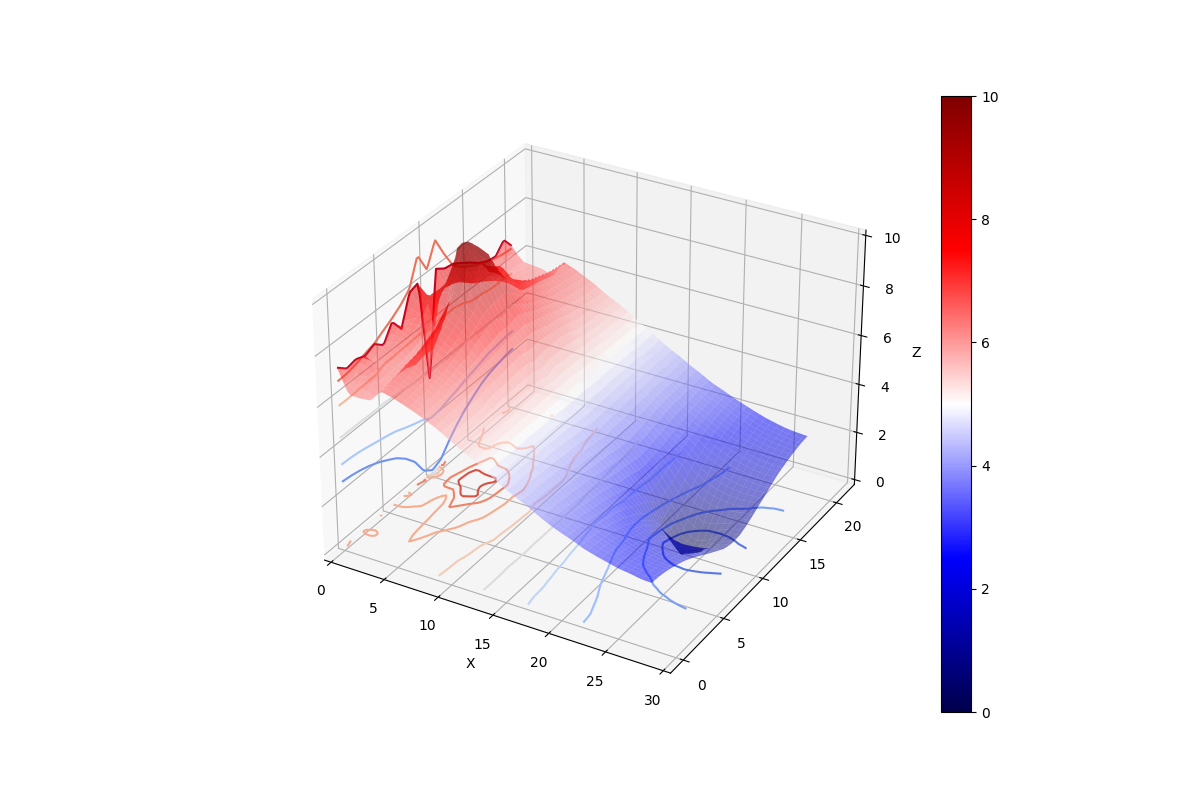

In [48]:
ax = plt.figure(figsize=(12,8)).add_subplot(projection='3d')


ax.plot_surface(ut, vt, interpolated_z, cmap='seismic', alpha=0.5)

ax.contour(ut, vt, interpolated_z, zdir='z', offset=0, levels=10, cmap='coolwarm')
ax.contour(ut, vt, interpolated_z, zdir='x', offset=0, levels=6, cmap='coolwarm_r')

ax.set(xlim=(0, 30), zlim=(0, 10), xlabel='X', zlabel='Z')

plt.colorbar(image, ax=ax)

plt.show()

## Fast Fourier Transform and fitting an arbitrary sum of functions

Many physics applications in scientific computing boil down to making fits. You have some data which highly resembles some familiar function and you need to find out parameters of the system and the easiest way might be to extrapolate that information by fitting a theoretical model to the data and computationally finding the best fitting parameter value.

Making fits in and of itself is quite easy. Polynomial fits are probably the easiest and can be done using numpys polyfit function. However as an enlightened physics student might realize, the world isn't created in such a way that all systems obey polynomial laws. Fortunately we have tools for fitting arbitrary functions to data.

Scipys optimize class has a function called <i>curve_fit</i>. This uses non-linear least squares methods to find best fitting parameters for a given function.

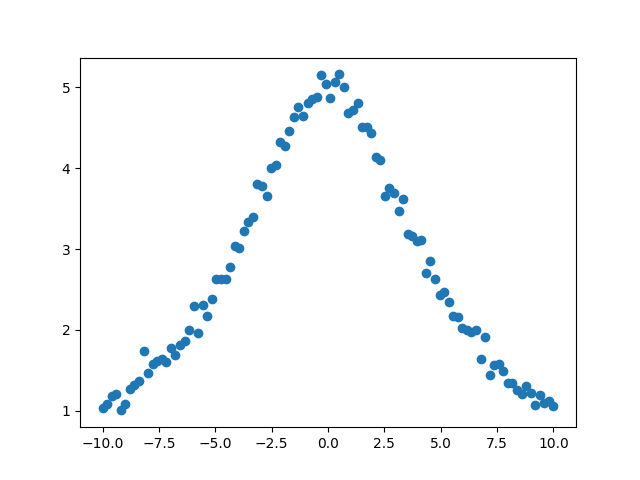

In [92]:
from scipy.optimize import curve_fit

def Lorentzian(x, x0, a, gam):
    return a * gam**2 / ((x - x0)**2 + gam**2)

# Create a dataset with a Lorentzian distribution
X = np.linspace(-10, 10, 100)
Y = Lorentzian(X, 0, 5, 5)

# Add some noise to the data
Y += np.random.normal(0, 0.1, 100)

# Plot the data
ax = plt.figure().add_subplot()
ax.plot(X, Y, 'o')
plt.show()

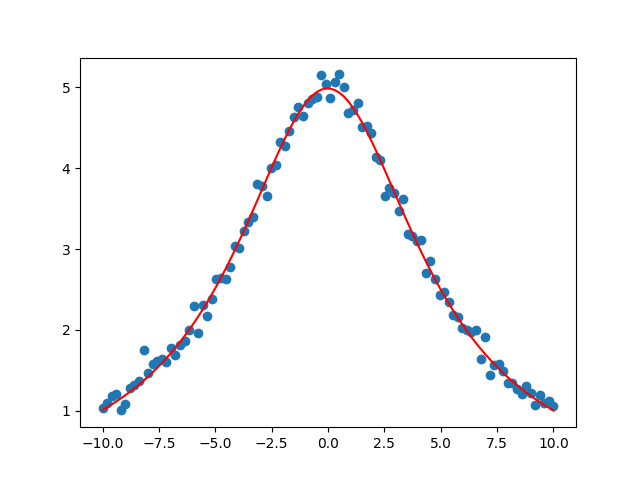

In [95]:
# Fit the data
popt, pcov = curve_fit(Lorentzian, X, Y, p0=[1, 1, 1])

# Plot the fit
ax = plt.figure().add_subplot()
ax.plot(X, Y, 'o')
ax.plot(X, Lorentzian(X, *popt), 'r-')
plt.show()

Now, before mowing on to a more demanding fit, why not take a detour into a very often used tool of applied mathematics: the Fast Fourier Transform.

Often times we have problems where some sort of periodicity is present, but it is not immediately obvious from the data. Or possibly finding the numerical value describing the frequency of this periodicity is essential and hard to do from the initial data. Say we have the following image:

![test4.png](test4.png)

We might want to find out the average width of the stripes in the image for some reason (this is an actual research question!). Now there is a periodic nature to this problem, but how does it manifest? Well, the width of the stripes is simply the average spacing between parallel lines in the image, of which there are many. So there is a repeating, periodic pattern in the image itself with a certain frequency of lines. And we can actually extract this information using 2D FFT!

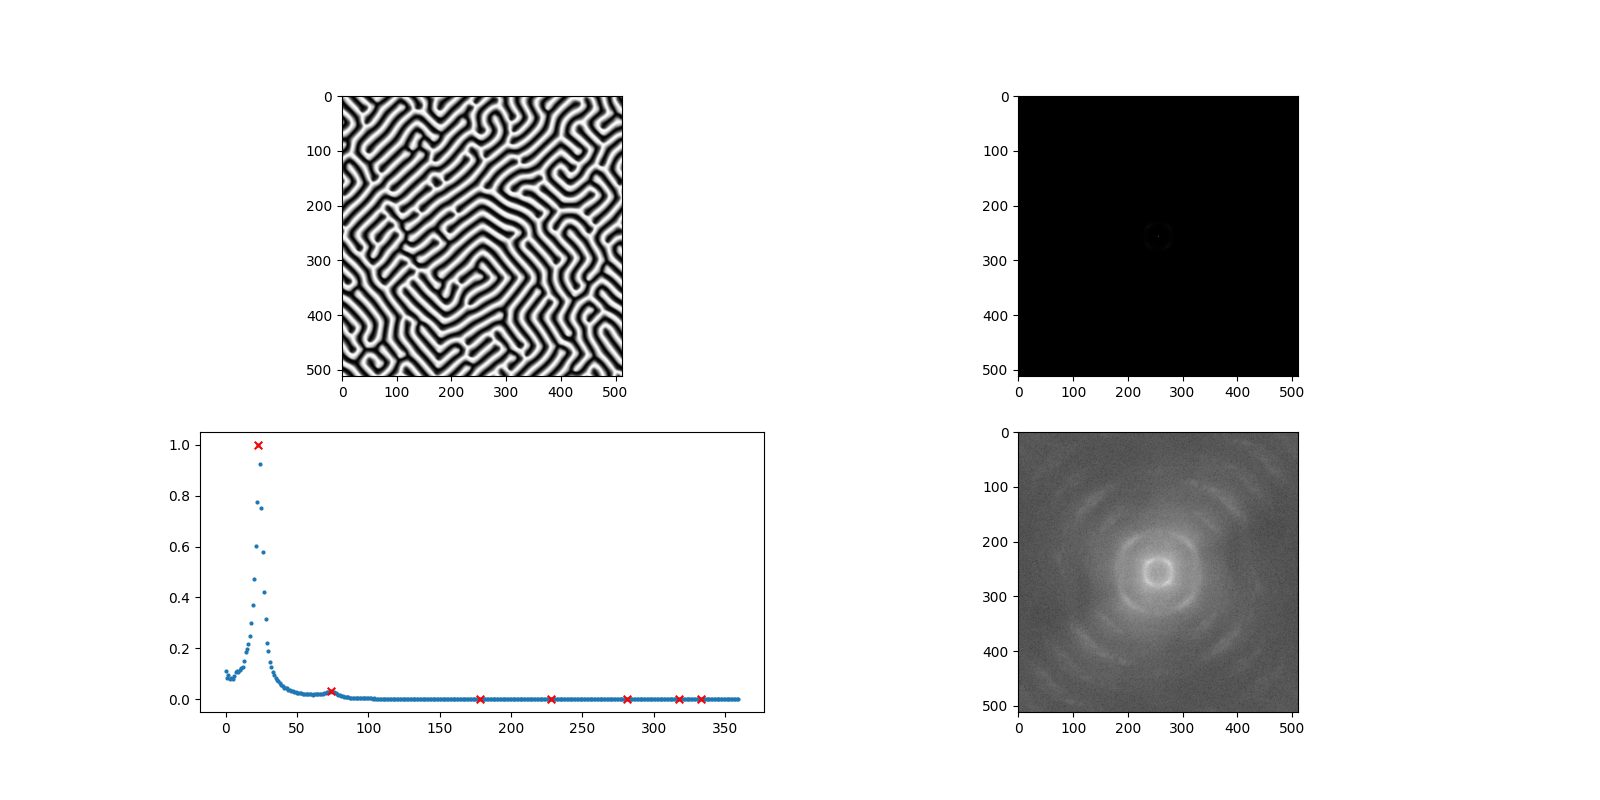

In [119]:
img = cv2.imread('test4.png',cv2.IMREAD_GRAYSCALE)


# Create the FFT of image
freq_space = np.fft.fft2(img)
# Shift the Fourier transform to the center
fshift = np.fft.fftshift(freq_space)
# Calculate the magnitude spectrum
magnitude_spectrum = 20*np.log(np.abs(fshift))
# The first one is the magnitude spectrum scaled such it can be interpreted as an image
# The second one is the magnitude spectrum without scaling, we will use this one for the radial profile
magnitude = np.abs(fshift)

fig, ax = plt.subplots(2,2, figsize=(16,8))



# Calculate the radial profile
# This gives us the average frequency ditribution or spectrum found in the image
rad_prof = radialProfile.azimuthalAverage(magnitude)
rad_prof = rad_prof[~np.isnan(rad_prof)]
rad_prof = (rad_prof-np.min(rad_prof))/(np.max(rad_prof)-np.min(rad_prof))

# Find the peaks in the radial profile
peaks, props = scipy.signal.find_peaks(rad_prof, width=4)


ax[0,0].imshow(img, cmap='gray')
ax[0,1].imshow(magnitude, cmap='gray')
ax[1,0].scatter(np.arange(len(rad_prof)), rad_prof, s=4)
ax[1,0].scatter(peaks, rad_prof[peaks], s=30, c='r', marker='x', zorder=10)
ax[1,1].imshow(magnitude_spectrum, cmap='gray')

Now we have some good actual frequency data. This signal seems to consist of Lorentzian peaks, so what we want to do is fit a sum of those. However to make our code more widely usable for different signals with a different number of peaks, let us create a function that calculates an arbitrary sum of lorentzian peaks!

[1.0, 23, 1, 0.03349690158034031, 74, 1, 0.0012576178149204236, 178, 1, 0.00034919314448250704, 228, 1, 0.0004200520886843194, 281, 1, 0.0002625444626471049, 318, 1, 0.0004999397334061611, 333, 1]
[ 9.20192387e-01  2.34498980e+01  2.88379113e+00  2.32060346e-02
  7.36771759e+01  4.84983054e+00 -3.17803551e-03  2.32982059e+02
 -7.35316356e+01  5.95426844e-02  1.68081418e+01 -5.27687540e+00
 -1.36410232e+00 -1.27526649e+02 -1.88856601e+02  3.94277840e+00
 -2.27958794e+02 -1.33897324e+02 -1.53184477e-02  3.62208600e+02
 -1.75952007e+02]


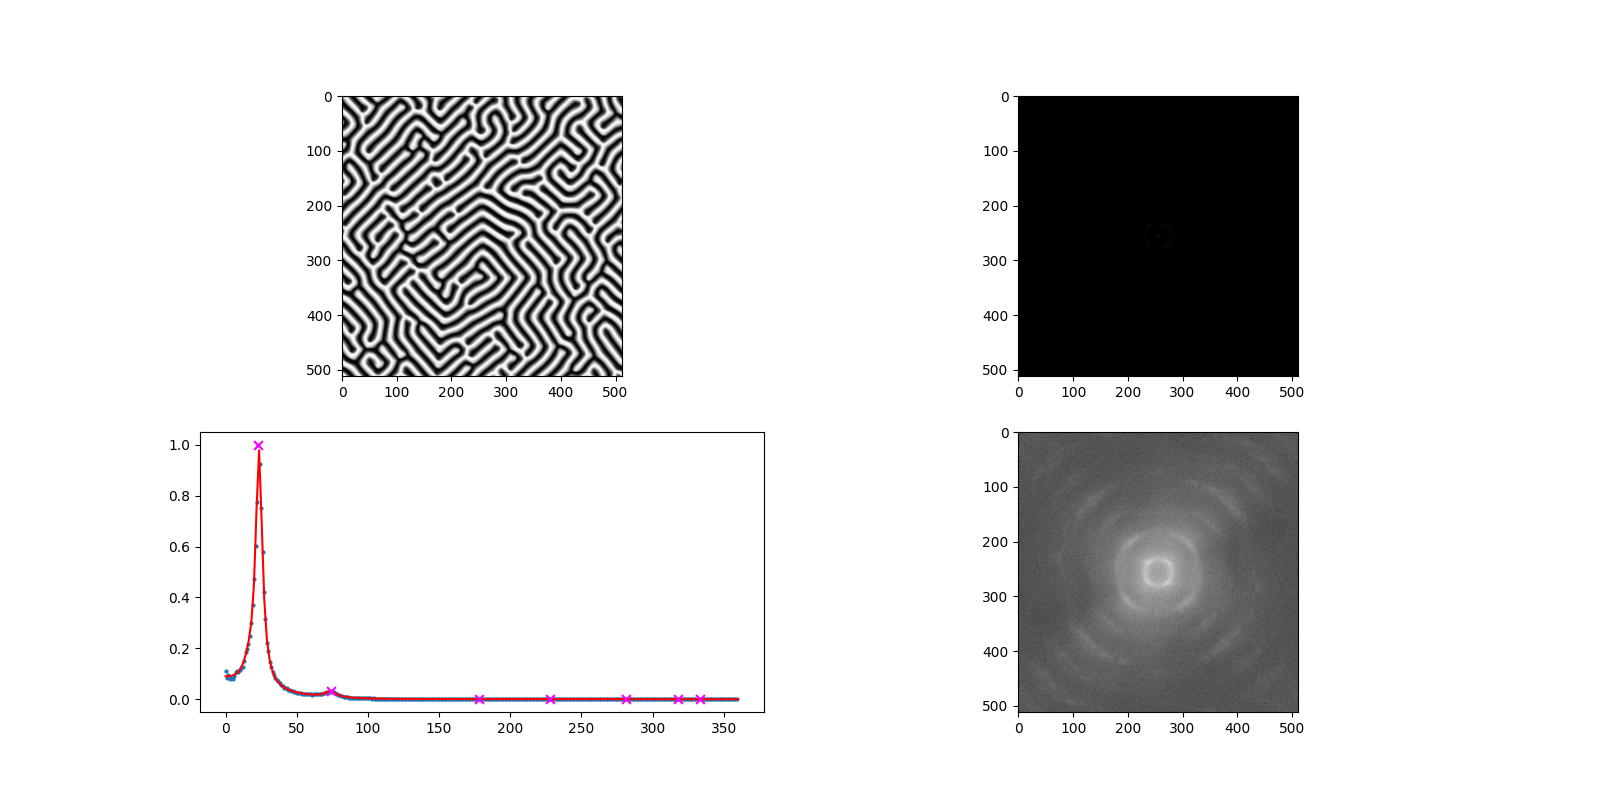

In [115]:
# Sum of Lorentzian functions
def sum_of_lorentzians(x, *params):
    y = 0
    for i in range(0, len(params), 3):
        y += lorentzian(x, params[i], params[i+1], params[i+2])
    return y

X = range(rad_prof.shape[0])

x_param = np.linspace(0,len(X), 200)

# Initialize parameter quesses: The height and the position of the peaks
n = len(peaks)
init_params = [1] * (3 * n)
for i in range(n):
    init_params[3*i+1] = peaks[i]
    init_params[3*i] = rad_prof[peaks[i]]

print(init_params)
params, _ = curve_fit(sum_of_lorentzians, X, rad_prof, list(init_params), maxfev=10000000)
print(params)



fig, ax = plt.subplots(2,2, figsize=(16,8))

ax[0,0].imshow(img, cmap='gray')
ax[0,1].imshow(magnitude, cmap='gray')
ax[1,0].scatter(np.arange(len(rad_prof)), rad_prof, s=4)
ax[1,0].scatter(peaks, rad_prof[peaks], s=40, c='magenta', marker='x', zorder=10)
ax[1,1].imshow(magnitude_spectrum, cmap='gray')
ax[1,0].plot(x_param, sum_of_lorentzians(x_param, *params), c='r')

plt.show()